In [ ]:
import os
import pandas as pd
import numpy as np
import chardet
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, MaxNLocator
import matplotlib.dates as mdates
from datetime import datetime, timedelta

from typing import List

pd.options.display.max_columns = 30

mapping_columns_names = {"Richtung": "direction",
                         "Sequenz": "sequence",
                         "FZ_AB": "departure_time",
                         "Einsteiger": "passenger_in",
                         "Aussteiger": "passenger_out",
                         "Besetzung": "passenger_amount",
                         "Distanz": "distance",
                         "Tage_DTV": "factor_average",
                         "Tage_DWV": "factor_workingDays",
                         "Tage_SA": "factor_saturday",
                         "Tage_SO": "factor_sunday",
                         "Nachtnetz": "night_flag",
                         "Tage_SA_N": "factor_saturday_night",
                         "Tage_SO_N": "factor_sunday_night",
                         "VSYS": "type_transport",
                         "Linienname_Fahrgastauskunft": "line_name",
                         "SITZPLAETZE": "seat_capacity",
                         "KAP_1m2": "passenger_capacity_1",
                         "KAP_2m2": "passenger_capacity_2",
                         "KAP_3m2": "passenger_capacity_3",
                         "KAP_4m2": "passenger_capacity_4",
                         "Haltestellenlangname": "stop_current"}

mapping_transport_type = {'TR': "Trolley Bus",
                          'T': "Tram",
                          'B': "Bus Urban",
                          'BP': "Bus P",
                          'BL': "Bus L",
                          'BZ': "Bus Z",
                          'FB': "Funicular",
                          'N': "Night Bus",
                          'BG': "Bus G",
                          'SB': "Cable car"}

carbon_footprint_intensity = pd.Series({
    "Car Fleet": 0.171*0.35+0.170*0.35+0.047*0.2+0.114*0.1, # Fleet of 35% diesel, 35% petrol, 20% electric, 10% motorbikes respectively
    "Bus G": 0.097,
    "Bus L": 0.097,
    "Bus P": 0.097,
    "Bus Urban": 0.097,
    "Bus Z": 0.097,
    "Cable car": 0.044,
    "Funicular": 0.0245,
    "Night bus": 0.097,
    "Tram": 0.029,
    "Trolley Bus": 0.097*0.5+0.047*0.5
}).to_frame().rename({0:"carbon_intensity"}, axis=1).rename({value: key for key, value in mapping_transport_type.items()},axis=0)

"""
Cable cars: Urban cable cars: Modern cable car systems open up new options for mobility in our cities” by Heiner Monheim et al. (2010, ksv-verlag)
Rest of type of vehicles: Data source: UK Government, Department for Energy Security and Net Zero (2022)
Funicular: https://oitaf2024.com/wp-content/uploads/2024/07/The-transport-capacity-of-a-cable-car-system-in-public-transportation_DEF-1.pdf
"""

def safe_decode(string):
    # Function to handle possible string errors as the Umlauts are not properly displayed
    try: 
        decoded_string = string.encode('latin1').decode('utf-8')
        return decoded_string
    except (UnicodeEncodeError, UnicodeDecodeError, AttributeError): # If there is any error encoding, it is already ok
        return string
    
def adjust_invalid_times(time_str):
    # Function to handle possible time errors as data include hours above 24h format
    hour = int(time_str[:2])
    if hour >= 24:
        return str(hour - 24) + time_str[2:]
    return time_str

def select_top_lines(serie, n=5):
    return serie.sort_values(ascending=False)[:n]


'\nCable cars: Urban cable cars: Modern cable car systems open up new options for mobility in our cities” by Heiner Monheim et al. (2010, ksv-verlag)\nRest of type of vehicles: Data source: UK Government, Department for Energy Security and Net Zero (2022)\nFunicular: https://oitaf2024.com/wp-content/uploads/2024/07/The-transport-capacity-of-a-cable-car-system-in-public-transportation_DEF-1.pdf\n'

In [ ]:
YEARS = np.arange(2020,2024,step=1)
FP_DATA = f'{os.path.dirname(os.getcwd())}/data'

########## LOAD AND WRANGLING ##########
pieces_per_year = []
for year in YEARS:

    # Read the main and auxiliary tables
    REISENDE = (pd.read_csv(f'{FP_DATA}/fahrgastzahlen_{year}/REISENDE.csv', sep=";")
                        .drop(["ID_Abschnitt","Tagtyp_Id","Anzahl_Messungen"], axis="columns"))
    LINIE = pd.read_csv(f'{FP_DATA}/fahrgastzahlen_{year}/LINIE.csv', sep=";")
    HALTESTELLEN = pd.read_csv(f'{FP_DATA}/fahrgastzahlen_{year}/HALTESTELLEN.csv', sep=";")
    GEFAESSGROESSE = pd.read_csv(f'{FP_DATA}/fahrgastzahlen_{year}/GEFAESSGROESSE.csv', sep=";")

    # Merge the tables based on their relations and clean unnecesary info
    reisende_linie = pd.merge(REISENDE, LINIE, how="left",
                          on=["Linien_Id", "Linienname"]).drop("Linienname", axis="columns")

    reisende_linie_haltestellen = (pd.merge(reisende_linie, HALTESTELLEN, how="left", on="Haltestellen_Id")
                               .drop(["Haltestellennummer", "Haltestellenkurzname"], axis='columns'))
    
    reisende_linie_haltestellen_co2 = (pd.merge(reisende_linie_haltestellen, carbon_footprint_intensity.drop("Car Fleet", axis="rows"),
                                                left_on="VSYS", right_index=True, how="left"))

    full_df_per_year = (pd.merge(reisende_linie_haltestellen_co2, GEFAESSGROESSE,
                            how="left", on="Plan_Fahrt_Id")
                      .drop(["Linien_Id", "Plan_Fahrt_Id"], axis="columns"))
    
    # Add the year of information
    full_df_per_year["year"] = year

    # Map the next haltstelle with its ID
    next_stop = pd.merge(REISENDE, HALTESTELLEN, how="left",
                                left_on="Nach_Hst_Id", right_on="Haltestellen_Id")["Haltestellenlangname"]
    
    full_df_per_year["stop_next"] = next_stop

    # Add to the list of pieces to further concat
    pieces_per_year.append(full_df_per_year)

# Concat all the pieces
data_processed = (pd.concat(pieces_per_year, ignore_index=True)
                  .drop(["Haltestellen_Id", "Nach_Hst_Id"], axis="columns")
                  .rename(mapping_columns_names, axis="columns"))

######### CLEAN AND TRANSFORM DATA #########

data = data_processed.copy()
# Decode possible wrong strings
data["stop_next"] = data["stop_next"].map(safe_decode)
data["stop_current"] = data["stop_current"].map(safe_decode)

# Map types of transport
data["type_transport"] = data["type_transport"].map(mapping_transport_type)

# Transform time_departure to datetime object
data["departure_time"] = data["departure_time"].map(adjust_invalid_times)
data["departure_time"] = pd.to_datetime(data["departure_time"], format="%H:%M:%S").dt.time

# Transform distance into km
data["distance"] = data["distance"] / 1000

# Drop duplicated
original_data = data.drop_duplicates()
data = original_data.copy()

# REPRESENTATION OF THE DATA

Text(0.5, 1.0, 'Number of passengers entering lines per year')

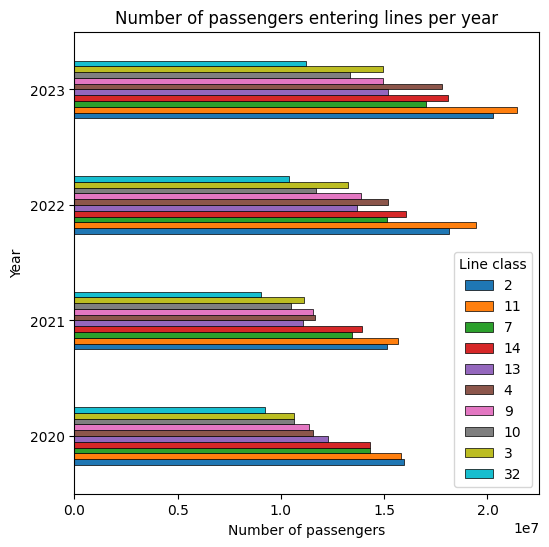

In [12]:
# Most used lines per year
fig, ax = plt.subplots(1,1,figsize=(6,6))
passenger_line_year.plot(kind="barh", edgecolor="black", linewidth=0.5,
                         ax=ax, ylabel="Year", xlabel="Number of passengers")
ax.set_title("Number of passengers entering lines per year")

Text(0.5, 1.0, 'Number of passengers travelling at specific time')

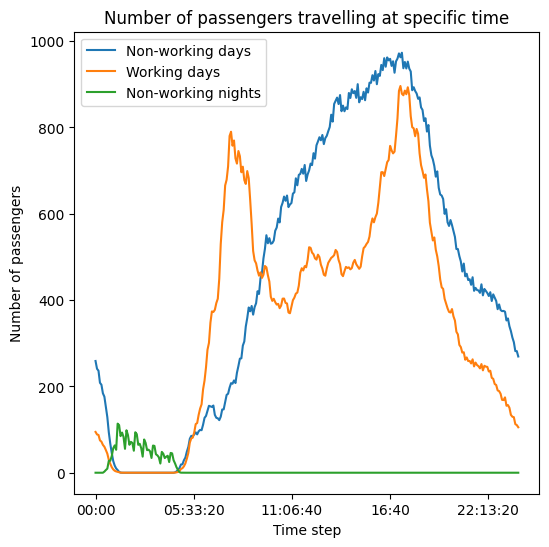

In [13]:
# Occupancy between days
fig, axes = plt.subplots(figsize=(6,6))
travel_times.plot(kind="line", ax=axes)
axes.set_xlabel("Time step")
axes.set_ylabel("Number of passengers")
axes.set_title("Number of passengers travelling at specific time")

Text(0.5, 0.98, 'Number of passengers travelling per vehicle, type of day and time')

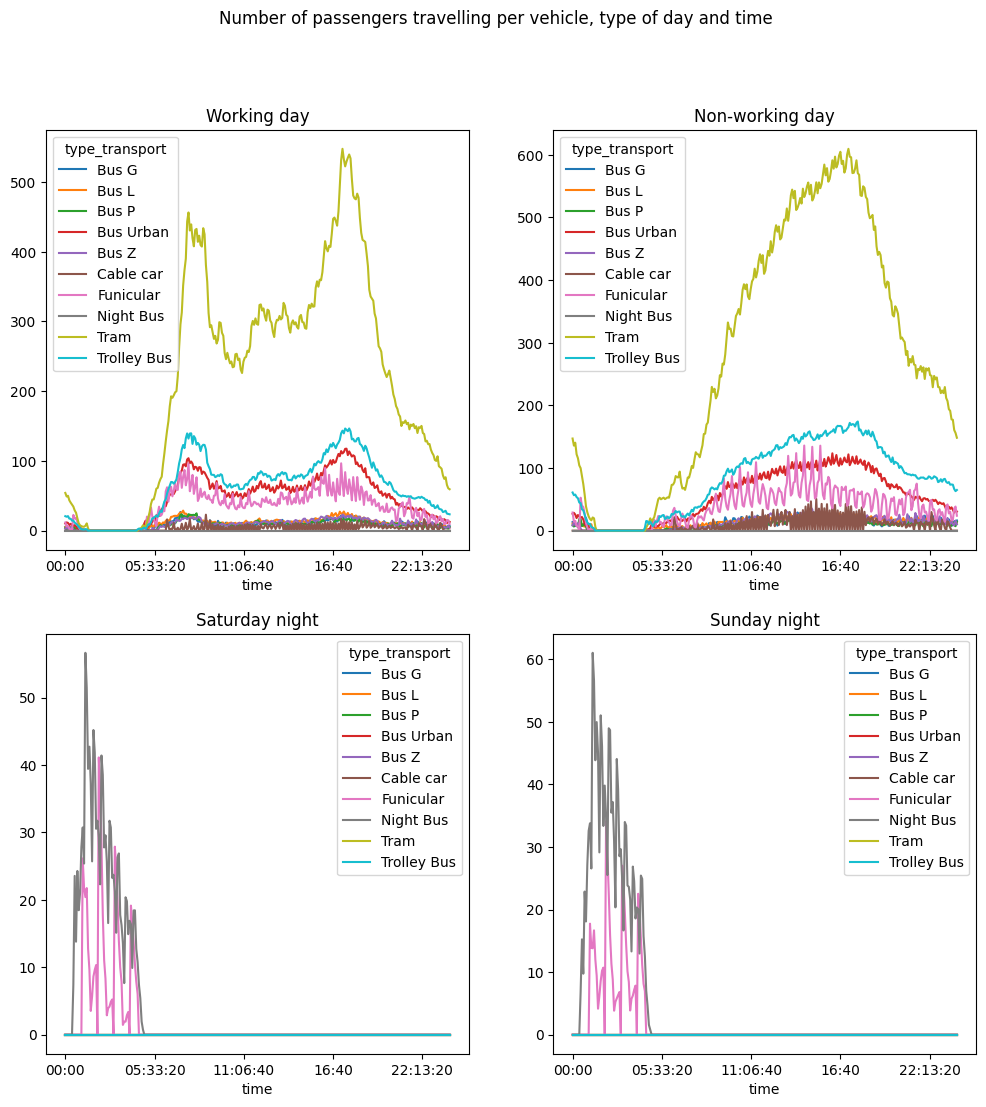

In [14]:
# Occupancy per vehicle used, day and time
fig, axes = plt.subplots(2,2, figsize=(12,12))
axes = axes.flatten()
time_vehicle_use["passenger_amount_WD"].fillna(0).plot(ax=axes[0])
time_vehicle_use["passenger_amount_NWD"].fillna(0).plot(ax=axes[1])
time_vehicle_use["passenger_amount_night_saturday"].fillna(0).plot(ax=axes[2])
time_vehicle_use["passenger_amount_night_sunday"].fillna(0).plot(ax=axes[3])

axes[0].set_title("Working day")
axes[1].set_title("Non-working day")
axes[2].set_title("Saturday night")
axes[3].set_title("Sunday night")

fig.suptitle("Number of passengers travelling per vehicle, type of day and time")

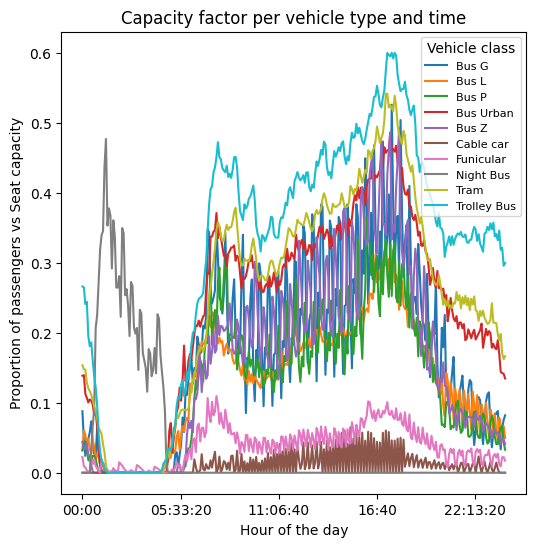

In [15]:
# Capacity factor per vehicle and time
fig, ax = plt.subplots(figsize=(6,6))
rateOcuppancy_vehicle_time.plot(ax=ax)
ax.set_xlabel("Hour of the day")
ax.set_ylabel("Proportion of passengers vs Seat capacity")
ax.set_title("Capacity factor per vehicle type and time")
ax.legend(fontsize=8, loc="upper right", title="Vehicle class")

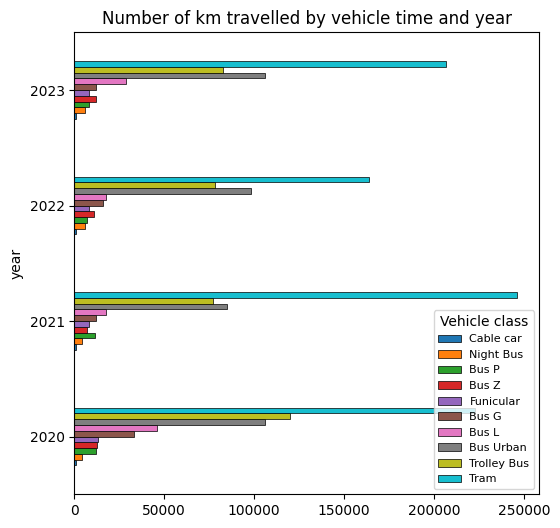

In [17]:
# Distance travelled per vehicle and year
fig, axes = plt.subplots(1,1, figsize=(6,6))
distance_vehicle_year.plot(kind="barh", width=0.5, edgecolor="black", linewidth=0.5, ax=axes)
axes.set_title("Number of km travelled by vehicle time and year")
axes.legend(fontsize=8, loc="lower right", title="Vehicle class")

Text(0.5, 1.0, 'Number of lines added')

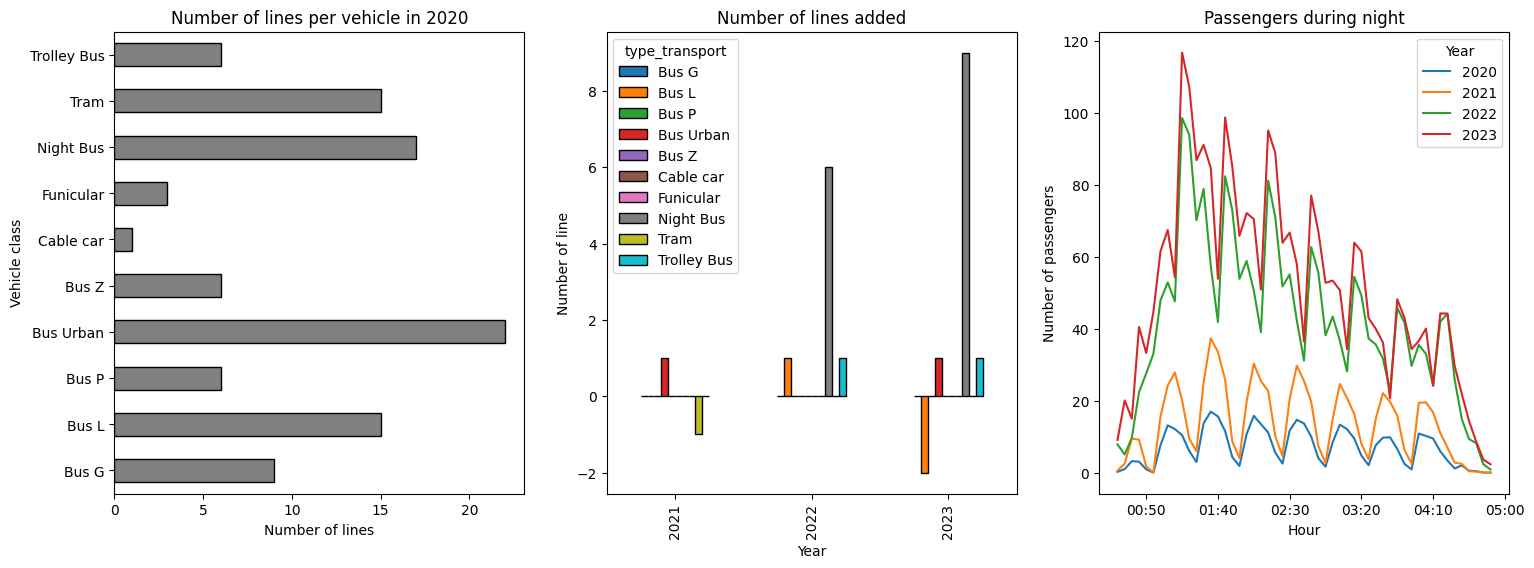

In [18]:
# Number of lines added per type of vehicle and year
fig, ax = plt.subplots(1,3, figsize=(18,6))
number_lines_per_vehicle_2020.plot(kind="barh", edgecolor="black", ax=ax[0], color="gray",
                                   ylabel="Vehicle class", xlabel="Number of lines",
                                   title="Number of lines per vehicle in 2020",
                                   legend=False)
(number_lines_per_vehicle_year.apply(lambda x: x-x[2020])
                              .loc[2021:]
                              .plot(kind="bar", edgecolor="black", ax=ax[1]))

travel_times_night.plot(kind="line", xlabel="Hour", ylabel="Number of passengers",
                        title="Passengers during night", ax=ax[2])
ax[2].xaxis.set_major_locator(MaxNLocator(nbins=6))
ax[2].legend(title="Year")

ax[1].set_xlabel("Year")
ax[1].set_ylabel("Number of line")
ax[1].set_title("Number of lines added")

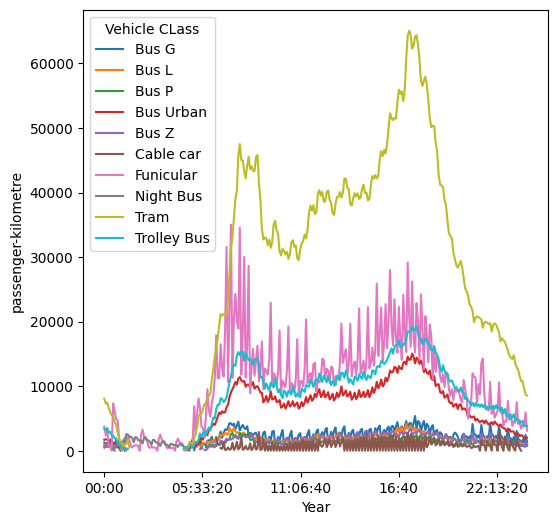

In [20]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
pkm_time_vehicle_year[2023].plot(ax=ax, xlabel="Year", ylabel="passenger-kilometre")
ax.legend(fontsize=10, title="Vehicle CLass")

In [ ]:
data["passenger_line_year"] = data["passenger_in"]*data["factor_average"]
data["occupancy_rate_0"] = data["passenger_amount"]/data["seat_capacity"]
data["passenger_amount_WD"] = data["passenger_amount"]*data["factor_workingDays"] / 251
data["passenger_amount_NWD"] = (data["passenger_amount"]*data["factor_saturday"]/52 + data["passenger_amount"]*data["factor_sunday"]/ 62) 
data["passenger_amount_night"] = ((data["passenger_amount"]*data["factor_saturday_night"])/52 + (data["passenger_amount"]*data["factor_sunday_night"])/62)
data["passenger_amount_night_saturday"] = (data["passenger_amount"]*data["factor_saturday_night"])/52
data["passenger_amount_night_sunday"] = (data["passenger_amount"]*data["factor_sunday_night"])/62
data["passenger_kilometre"] = data["passenger_amount"]*data["distance"]*data["factor_average"]
data["passenger_kilometre_co2"] = data["passenger_kilometre"]*data["carbon_intensity"]

# Data filter to year 2023
data_year = data[data["year"]==2023]

######### PASSENGER METRICS ########

# Passenger metrics: Number of passengers per year and line
passenger_line_year = (data.pivot_table(index="year", columns="line_name",
                                       values="passenger_line_year", aggfunc="sum")
                            .T.sort_values(by=2020, ascending=False).T).iloc[:,:10]
passenger_line_year.columns.name = "Line class"

# Passenger metrics: Total number of passengers per year
passenger_year = passenger_line_year.sum(axis=1)

# Passenger metrics: Peak travel times on working days vs weekend days.
travel_times = data_year.pivot_table(index="departure_time",
                                values=["passenger_amount_WD", "passenger_amount_NWD","passenger_amount_night"],
                                aggfunc="sum")
travel_times.index = pd.to_datetime(travel_times.index, format="%H:%M:%S")
travel_times = travel_times.resample("5min").mean().rename({"passenger_amount_NWD": "Non-working days",
                                                             "passenger_amount_WD": "Working days",
                                                             "passenger_amount_night": "Non-working nights"}, axis=1)
travel_times.index = travel_times.index.time

# Passenger metric: Number of passengers during night per vehicle type 
travel_times_night = data.pivot_table(index="departure_time", columns="year",
                                      values="passenger_amount_night", aggfunc="sum")
travel_times_night = travel_times_night[travel_times_night.values>0]
travel_times_night.index = pd.to_datetime(travel_times_night.index, format="%H:%M:%S")
travel_times_night = travel_times_night.resample("5min").mean()
travel_times_night.index = travel_times_night.index.time

# Passenger metrics: Type of vehicle used per time
time_vehicle_use = data_year.pivot_table(index="departure_time", columns="type_transport",
                                         values=["passenger_amount_WD", "passenger_amount_NWD",
                                                 "passenger_amount_night", "passenger_amount_night_saturday",
                                                 "passenger_amount_night_sunday"],
                                         aggfunc="sum")
time_vehicle_use.index = pd.to_datetime(time_vehicle_use.index, format="%H:%M:%S")
time_vehicle_use = time_vehicle_use.resample("5min").mean()
time_vehicle_use.index = time_vehicle_use.index.time
time_vehicle_use.columns.name = "Vehicle class"

# Passenger metric: passenger-kilometer per vehicle type, year and line
pkm_time_vehicle_year = data.pivot_table(index=["departure_time"], columns=["year","type_transport"],
                                    values="passenger_kilometre", aggfunc="sum")
pkm_time_vehicle_year.index = pd.to_datetime(pkm_time_vehicle_year.index, format="%H:%M:%S")
pkm_time_vehicle_year = pkm_time_vehicle_year.resample("5min").mean()
pkm_time_vehicle_year.index = pkm_time_vehicle_year.index.time

######### INFRASTRUCTURE METRICS ########

# Number of lines per type of vehicle
number_lines_per_vehicle_year = (data.groupby(["year", "type_transport"])[["line_name"]]
                                 .nunique()
                                 .unstack())
number_lines_per_vehicle_year.columns = number_lines_per_vehicle_year.columns.droplevel(0)
number_lines_per_vehicle_2020 = number_lines_per_vehicle_year.T[[2020]]

# Ocuppancy rates: Display occupancy rates of vehicles based on seating capacity
rateOcuppancy_vehicle_time = data_year.pivot_table(index="departure_time", columns="type_transport",
                                                   values="occupancy_rate_0").fillna(0)
rateOcuppancy_vehicle_time.index = pd.to_datetime(rateOcuppancy_vehicle_time.index, format="%H:%M:%S")
rateOcuppancy_vehicle_time = rateOcuppancy_vehicle_time.resample("5min").mean()
rateOcuppancy_vehicle_time.index = rateOcuppancy_vehicle_time.index.time
rateOcuppancy_vehicle_time.columns.name = "Vehicle class"


######### DISTANCE AND TIME METRICS #########

# Distance travelled per vehicle and year
distance_vehicle_year = (data.pivot_table(index="year", columns="type_transport",
                                         values="distance", aggfunc="sum")
                             .T.sort_values(by=2020, ascending=True).T)
distance_year = pd.DataFrame(distance_vehicle_year.sum(axis="columns"),columns=["Distance travelled"]).T

######### EMISSIONS METRICS ##########
distance_total = data.pivot_table(index="year", values="distance", aggfunc="sum")
passenger_total = data.pivot_table(index="year", values="passenger_amount", aggfunc="sum")
pkm_total = data.pivot_table(index="year", values="passenger_kilometre", aggfunc="sum")

pkm_co2_year_vehicle = data.pivot_table(index="year", columns="type_transport",
                                        values="passenger_kilometre_co2", aggfunc="sum")

pkm_co2_car = pkm_total * carbon_footprint_intensity.loc["Car Fleet"].iloc[0]
saved_co2 = pkm_co2_car.sub(pkm_co2_year_vehicle.sum(axis=1), axis="rows")/1000